In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import datetime
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn import linear_model
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestRegressor
import time
import cPickle as pickle
import statsmodels.api as sm


import qgrid

%load_ext autoreload
%autoreload 2

from functions import *
from plots import *

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8  # plotsize 

#qgrid.nbinstall(overwrite=True)
#qgrid.show_grid(df[['open_lifts', 'new_24']], remote_js=True)

## Import Data

In [2]:
df = pd.DataFrame.from_csv('../data_ski_in_solitude/data_with_features/all_feat.csv', parse_dates=True, index_col=0)

#### Drop the NaNs and inf scale data

In [3]:
df = df.replace([np.inf, -np.inf], np.nan)
df.fillna(0, inplace=True)

#### Scale the skier numbers

In [4]:
ref_column = 'skiers'
sc_skiers = scale_skiers(df, (0,100), ref_column)
sc_skiers = [round(crowd, 0) for crowd in sc_skiers]
df['skiers'] = sc_skiers

In [5]:
features = list(df.columns.values)
features.remove('skiers')

### Create a training and holdout set

In [6]:
df_tr = pd.concat([df.ix[datetime.datetime(2011,11,1):datetime.datetime(2012,5,1)],df.ix[datetime.datetime(2013,11,1):datetime.datetime(2015,5,1)]], axis=0)
df_h = df.ix[datetime.datetime(2012,11,1):datetime.datetime(2013,5,1)]
df_fut = df.ix[datetime.datetime(2015,5,1):]
df_cv = df.ix[datetime.datetime(2011,11,1):datetime.datetime(2015,5,1)]

## Forward selection

In [7]:
lin_regr = linear_model.LinearRegression()

In [8]:
ref_column = 'skiers'
features = list(df_tr.columns.values)
features.remove('skiers')

In [9]:
len(features)

409

In [10]:
X_tr = df_tr[features]
y_tr = df_tr.skiers.values
X_h = df_h[features].values

In [11]:
dec_pos = list(df_tr.index.get_indexer_for(df_tr[df_tr.month_12 == 1].index))
mar_pos = list(df_tr.index.get_indexer_for(df_tr[df_tr.month_3 == 1].index))
apr_pos = list(df_tr.index.get_indexer_for(df_tr[df_tr.month_4 == 1].index))
X_tr_dec = df_tr.iloc[dec_pos][features]
X_tr_mar = df_tr.iloc[mar_pos][features]
X_tr_apr = df_tr.iloc[apr_pos][features]
y_tr_mar = df_tr.iloc[mar_pos].skiers
y_tr_apr = df_tr.iloc[apr_pos].skiers
y_tr_dec = df_tr.iloc[dec_pos].skiers

In [51]:
leave_out = []
features_input = [f for f in features if f not in leave_out]

In [52]:
fs_features, RMSE = forward_selection_lodo(lin_regr, X_tr, y_tr, 35, features_input, y_tr_mar, y_tr_apr, y_tr_dec, mar_pos, apr_pos, dec_pos)

Next best Feature:  basedepth_xmas , RMSE:  18.5 #: 1
Next best Feature:  open_lifts_sq , RMSE:  16.2 #: 2
Next best Feature:  open_trails , RMSE:  13.6 #: 3
Next best Feature:  day_6 , RMSE:  12.9 #: 4
Next best Feature:  6day_snow_tot_xmas_sqrt , RMSE:  12.4 #: 5
Next best Feature:  week_snow_tot_sat , RMSE:  12.0 #: 6
Next best Feature:  thanksgiv_fri , RMSE:  11.8 #: 7
Next best Feature:  pres_day , RMSE:  11.8 #: 8
Next best Feature:  pres_day_midweek , RMSE:  11.6 #: 9
Next best Feature:  thanksgiv_sat , RMSE:  11.5 #: 10
Next best Feature:  basedepth_sq , RMSE:  11.4 #: 11
Next best Feature:  month_4 , RMSE:  10.7 #: 12
Next best Feature:  before_xmas , RMSE:  10.7 #: 13
Next best Feature:  mlk_day , RMSE:  10.6 #: 14
Next best Feature:  ln_open_percent_sat , RMSE:  10.4 #: 15
Next best Feature:  month_1_xmas , RMSE:  10.3 #: 16
Next best Feature:  pres_day_fri , RMSE:  10.3 #: 17
Next best Feature:  thanksgiv , RMSE:  10.3 #: 18
Next best Feature:  4day_snow_tot_xmas , RMSE:  1

#### Plot the change in error with each additional feature.

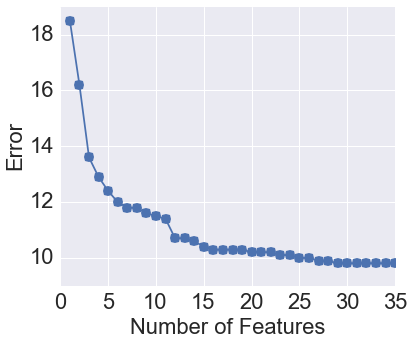

In [53]:
plot_error_vs_features(RMSE, 'none', 'none')

#### Plot the cv fit and learning curve at each step.

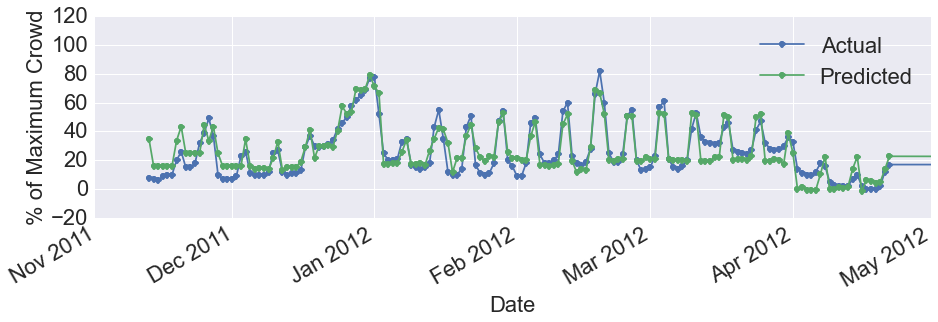

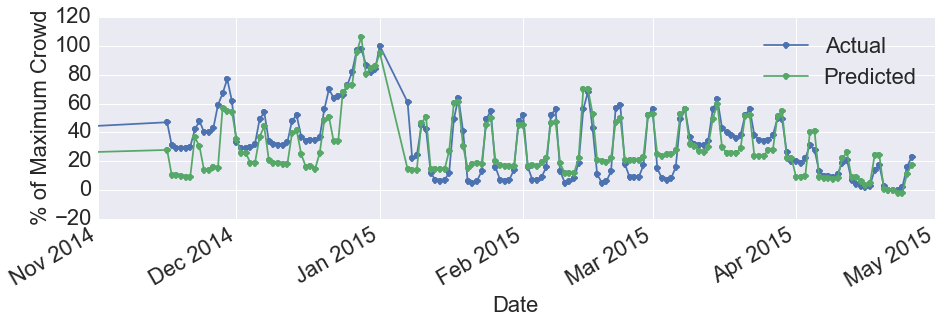

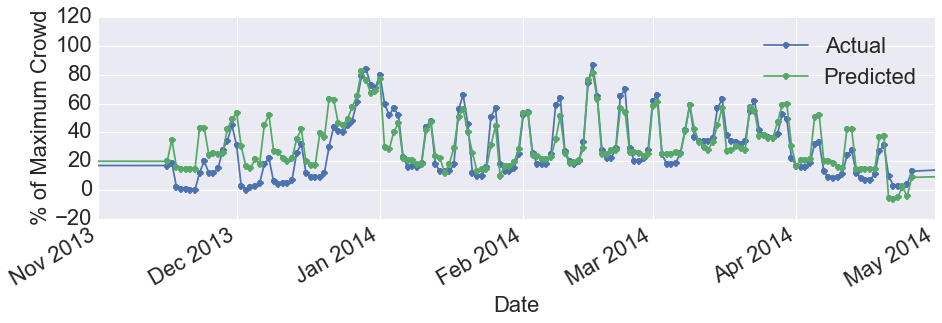

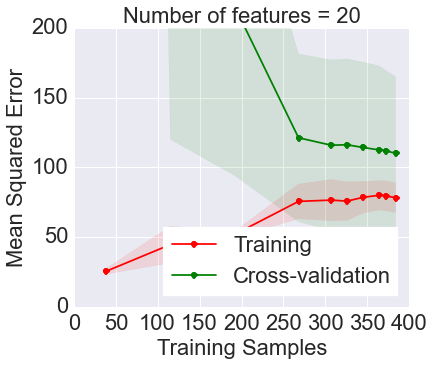

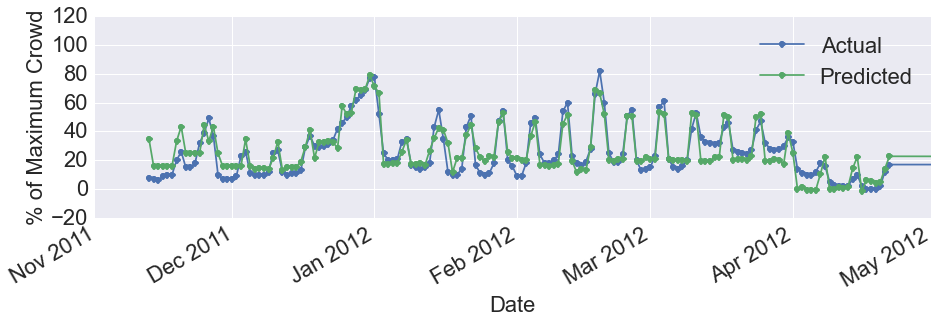

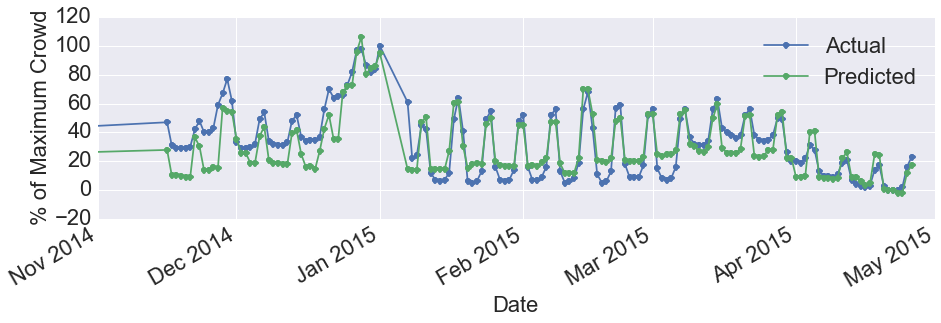

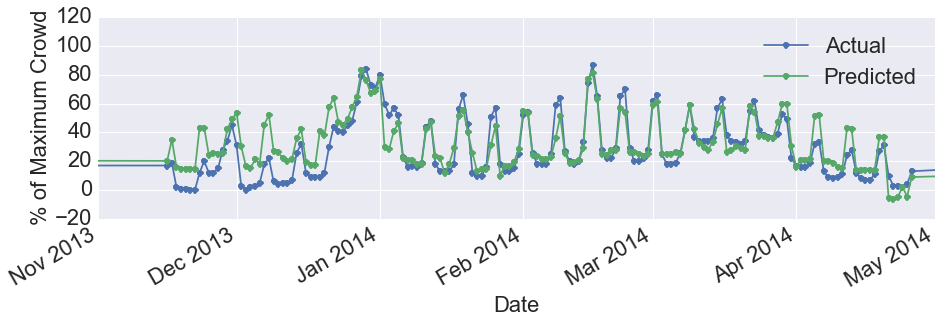

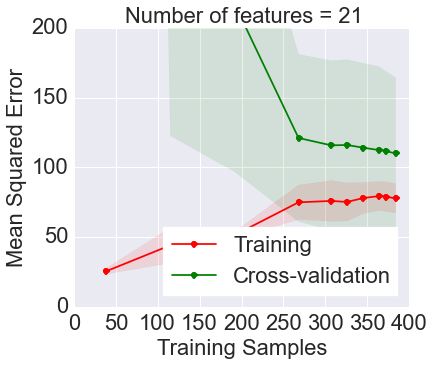

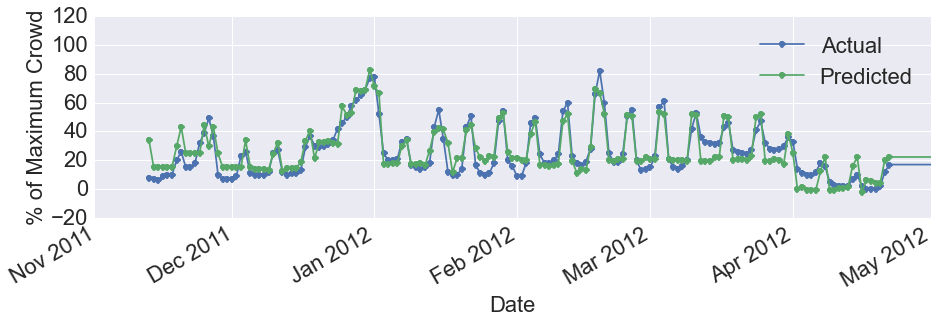

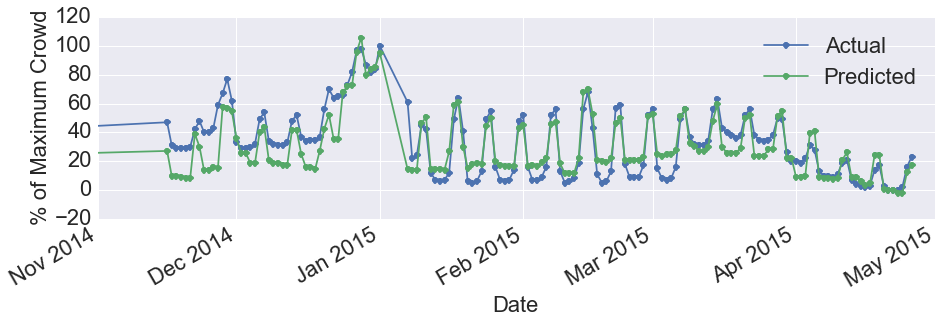

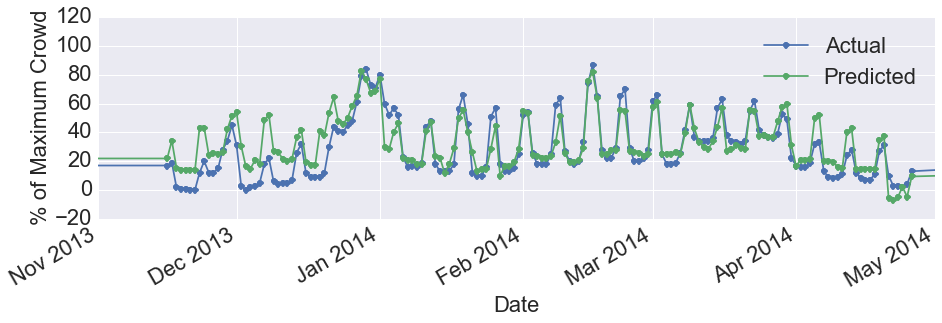

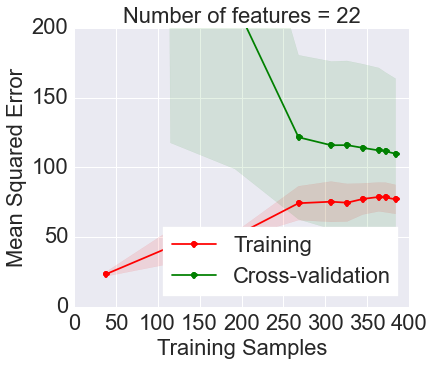

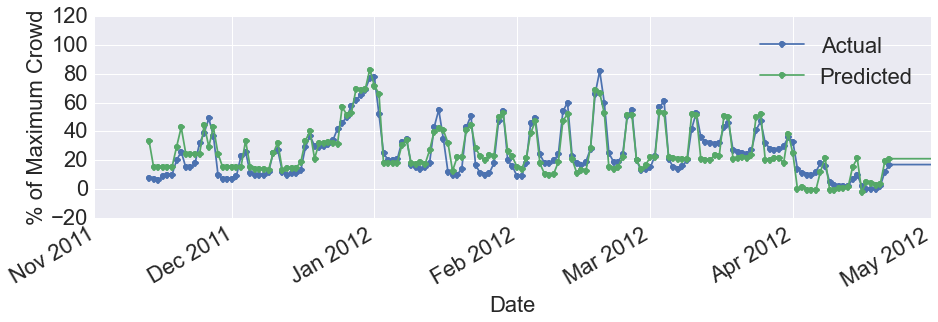

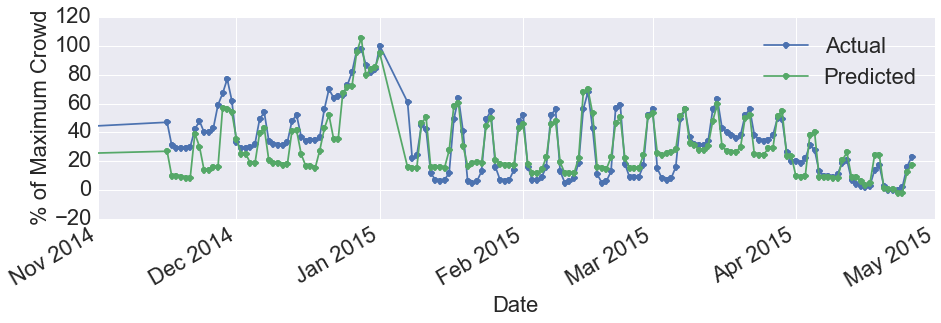

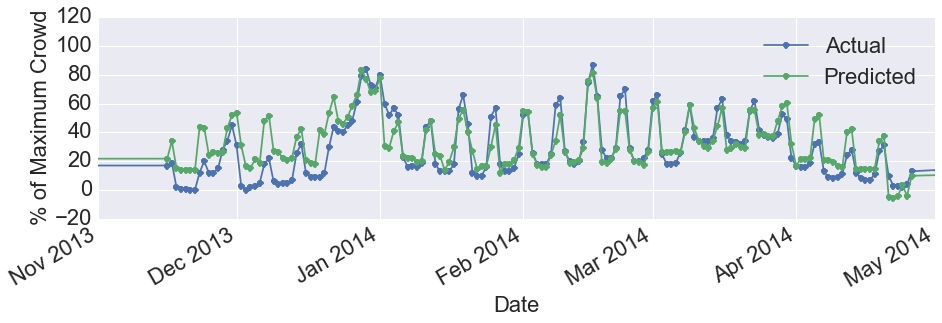

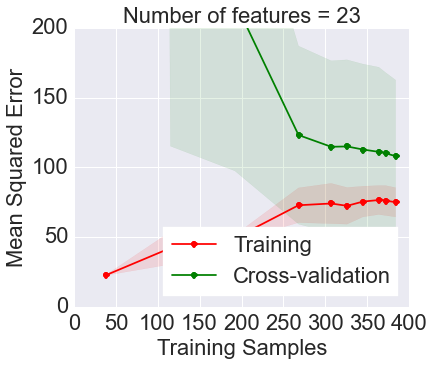

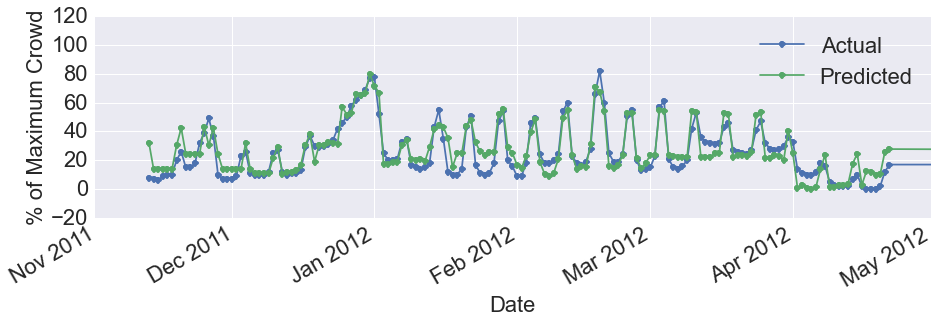

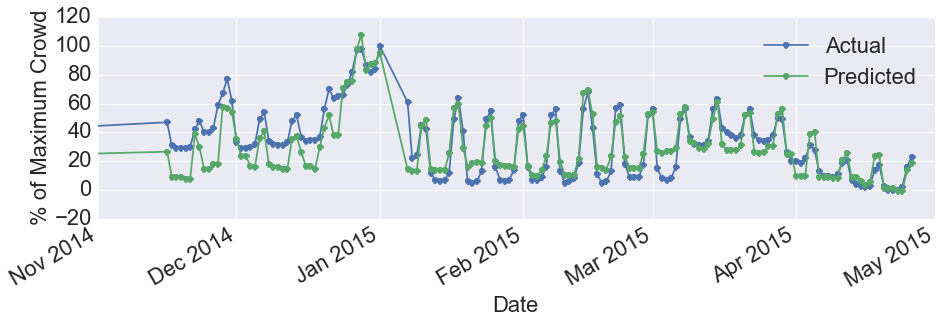

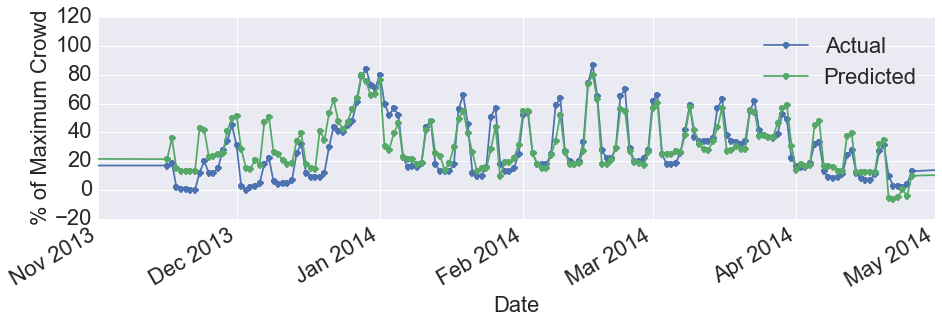

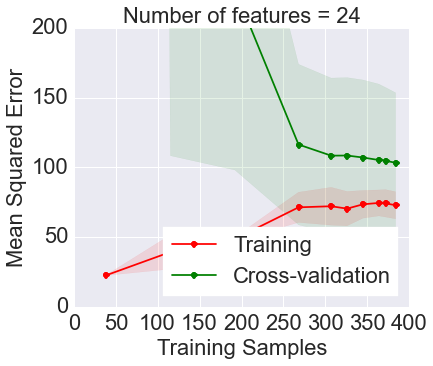

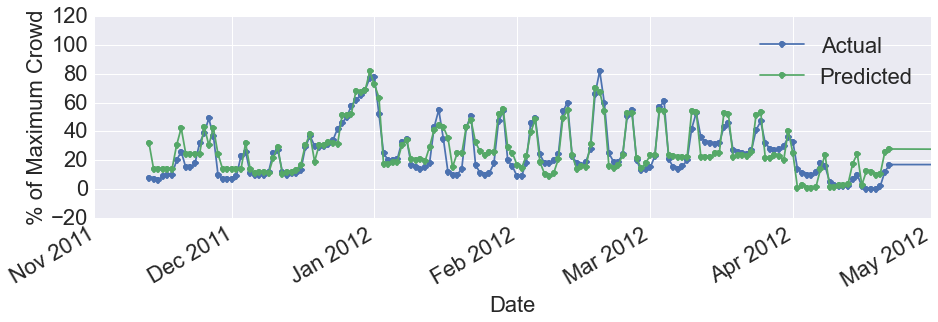

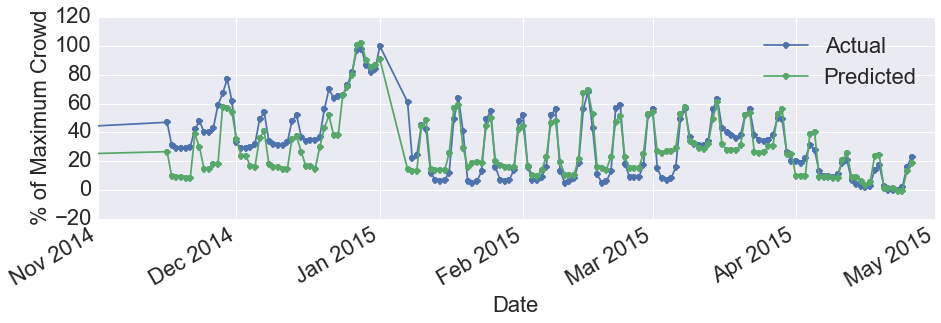

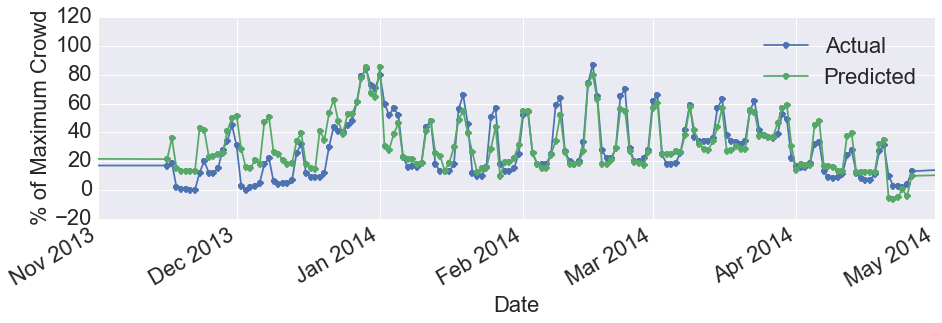

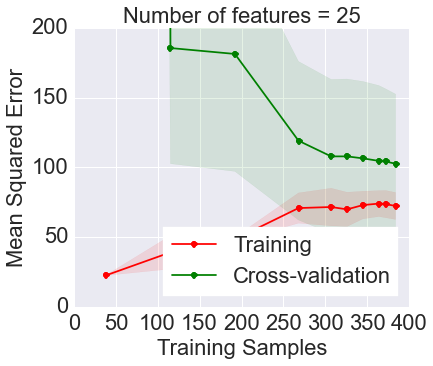

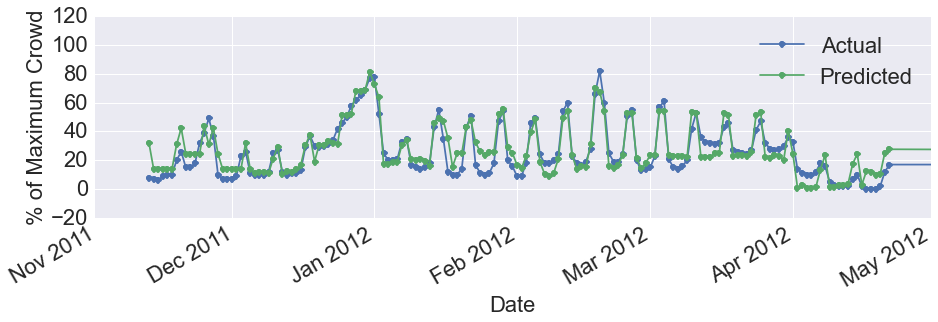

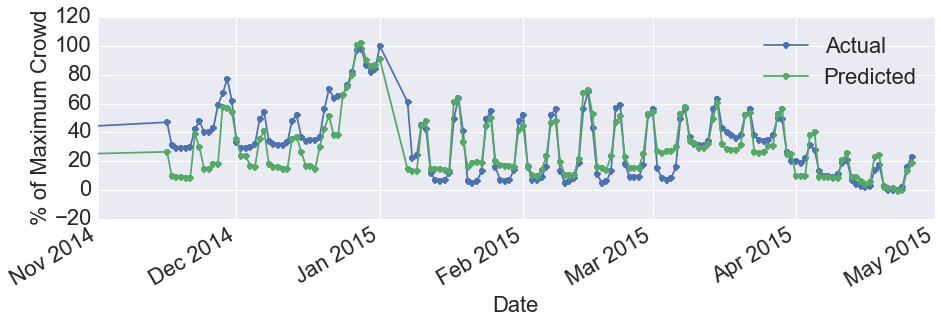

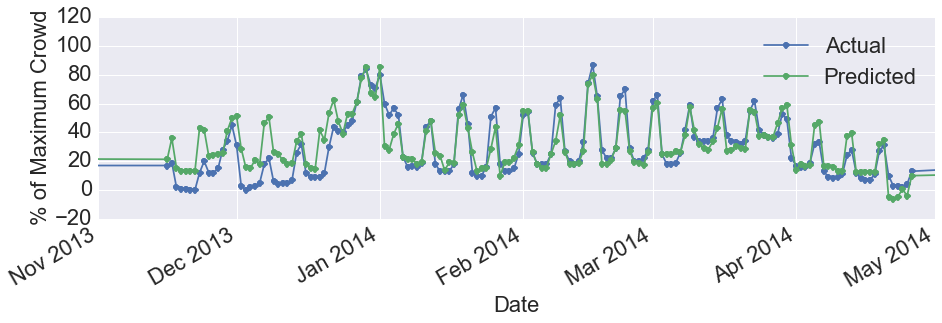

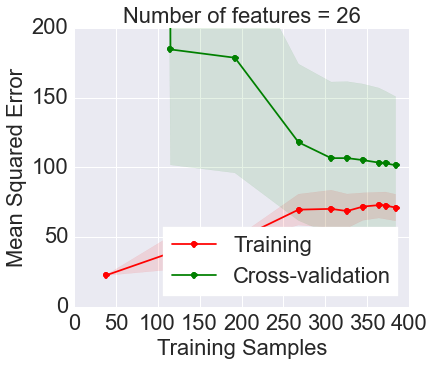

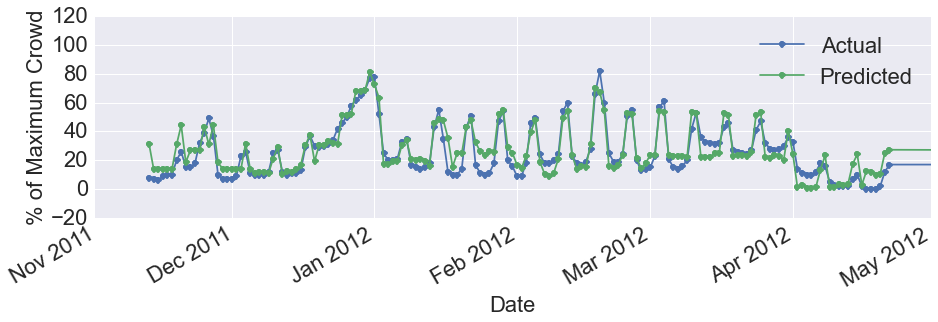

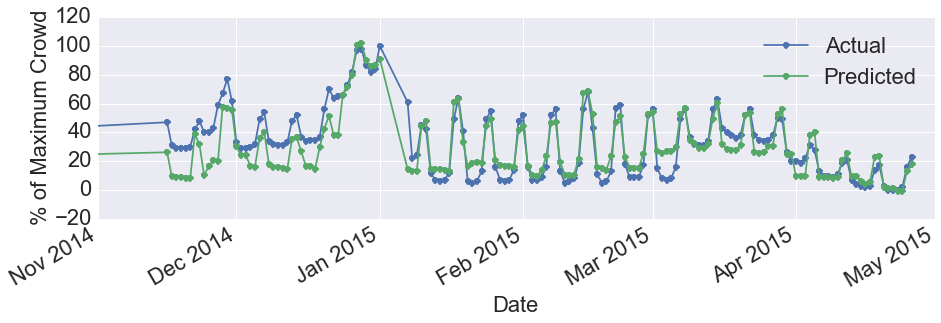

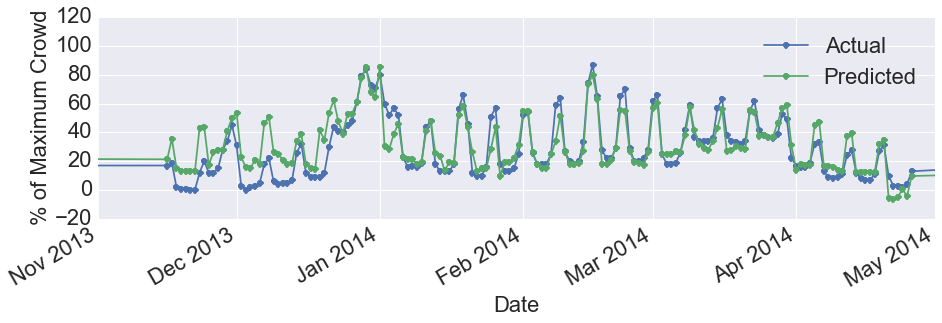

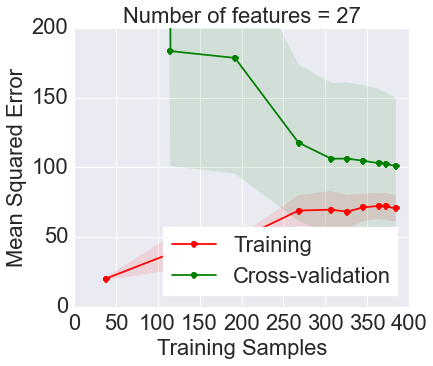

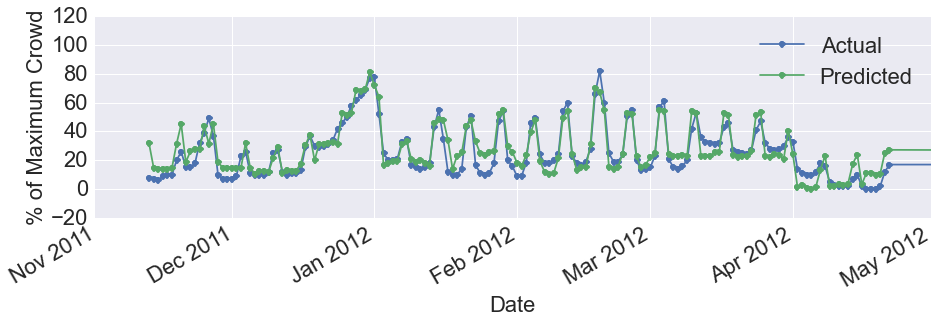

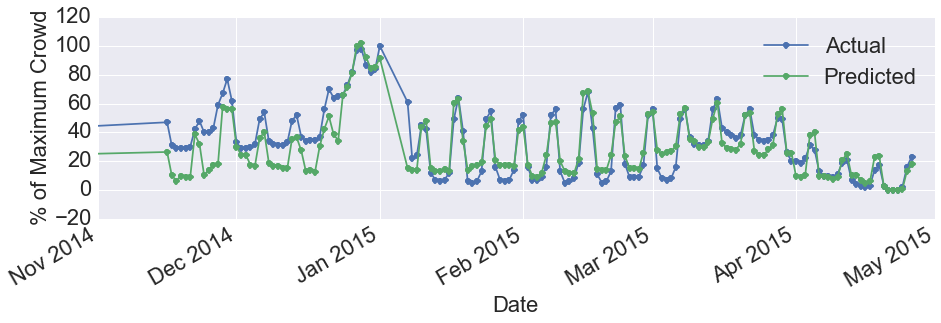

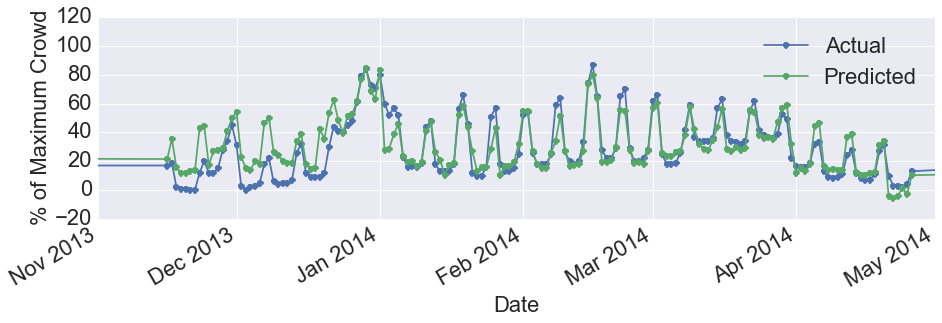

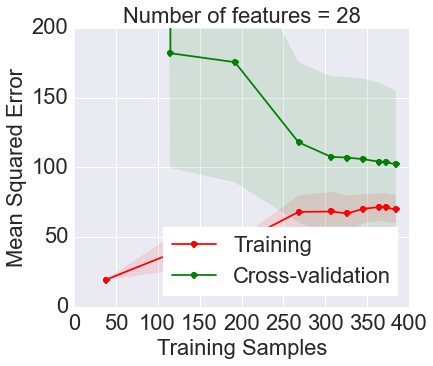

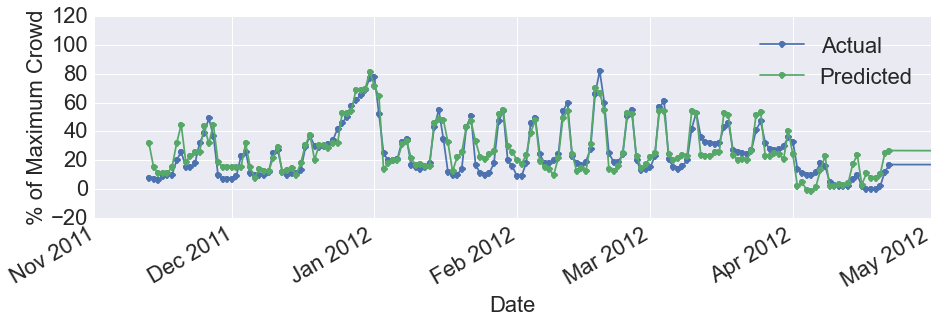

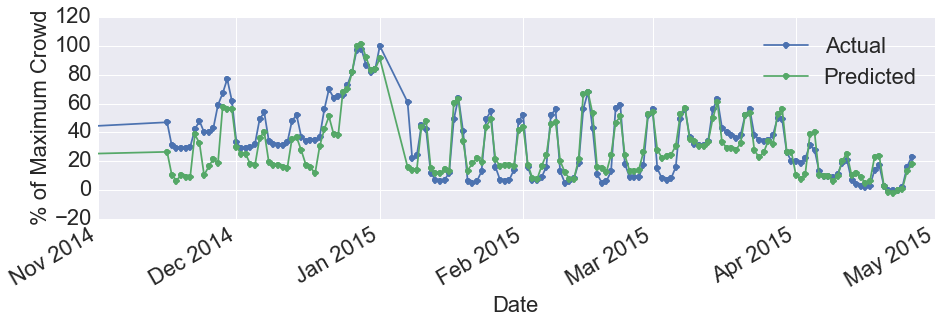

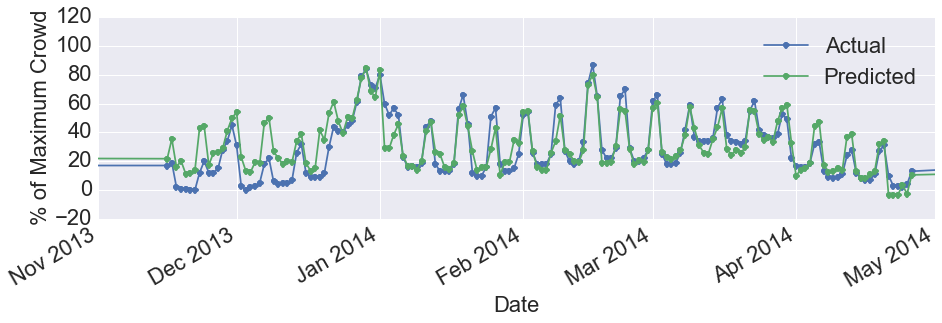

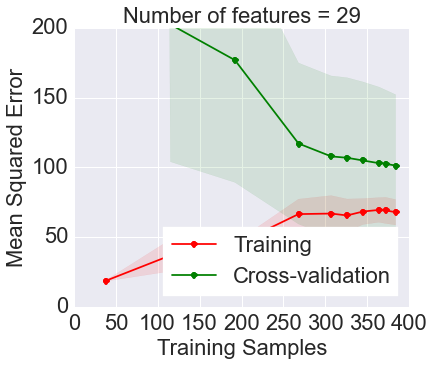

In [54]:
i = 20
while i < 30:
    num_good_feat = i
    df_reg = pd.concat([df_tr.skiers, df_tr[fs_features[0:i]]], axis=1)
    X_tr = df_tr[fs_features[0:i]]
    y_tr = df_tr.skiers.values
    mdl = lin_regr.fit(X_tr, y_tr) 
    cv_pred = cross_val_predict(lin_regr, X_tr, y_tr, cv = 10)
    df_reg['pred'] = cv_pred
    plot_fitted_and_ref_vs_time(df_reg, ref_column, ['2011-11-1 00:00:00', '2012-05-1 00:00:00'], 1200, (15, 4), '% of Maximum Crowd')
    plot_fitted_and_ref_vs_time(df_reg, ref_column, ['2014-11-1 00:00:00', '2015-05-1 00:00:00'], 1200, (15,4), '% of Maximum Crowd')
    plot_fitted_and_ref_vs_time(df_reg, ref_column, ['2013-11-1 00:00:00', '2014-05-1 00:00:00'], 1200, (15,4), '% of Maximum Crowd')
    plot_learning_curve(lin_regr, "Number of features = " + str(i), df_tr[fs_features[:i]].values, df_tr[ref_column].values, (0,200), 5, np.array([0.1, 0.3, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95,0.97, 1.0]))
    i += 1

In [12]:
fs_features = ['basedepth_xmas', 'open_lifts_sq', 'open_trails', 'day_6', '6day_snow_tot_xmas_sqrt', 'month_4', 'week_snow_tot_sat_sqrt', 'basedepth', 'ln_week_snow_tot_midweek', 'thanksgiv', 'before_xmas', 'pres_day', 'pres_day_midweek', 'ln_6day_snow_tot_sat', 'thanksgiv_fri', 'pres_day_fri', 'mlk_day', 'ln_week_snow_tot', 'ln_5day_snow_tot_sat', 'ln_3day_snow_tot_sat', 'thanksgiv_mon', 'month_1_xmas', 'month_2_midweek', 'mlk_day_fri', '4day_snow_tot_xmas_sqrt', 'month_2_sat', 'pres_day_sat', 'before_xmas_fri', 'ln_4day_snow_tot_xmas', '5day_snow_tot', 'ln_5day_snow_tot', 'pres_day_mon', 'month_1_mon', 'mlk_day_sat', 'month_2_fri']

#### Select the number of features and find the cv and holdout RMSE and predictions.

In [67]:
num_feat = 27
best_features= fs_features[0:num_feat]
RMSE_H_lin, RMSE_CV, df_H_lin, df_cv_lin = get_holdout_RMSE(lin_regr, best_features, df_tr, df_h, ref_column)

CV RMSE: 9.8 ,  Holdout RMSE: 10.6


### Cross Validation Fit

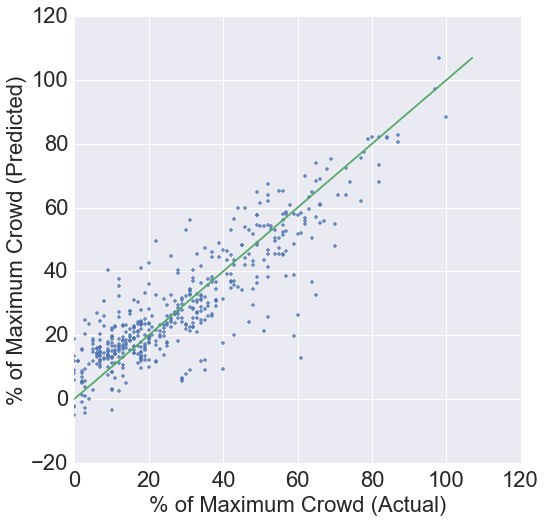

In [68]:
fitted_vs_ref_plot(df_cv_lin, ref_column, '% of Maximum Crowd (Predicted)', '% of Maximum Crowd (Actual)')

### Holdout Fit

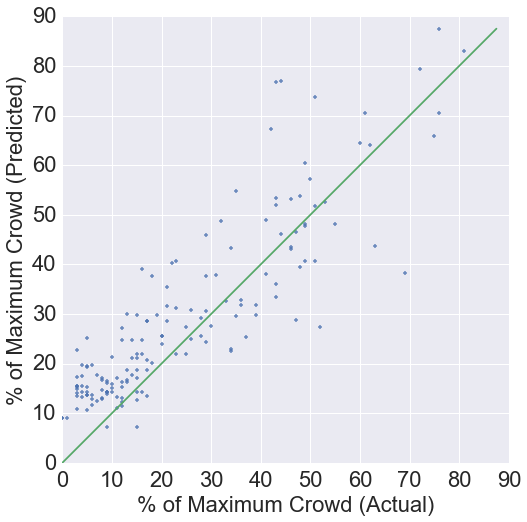

In [69]:
fitted_vs_ref_plot(df_H_lin, ref_column, '% of Maximum Crowd (Predicted)', '% of Maximum Crowd (Actual)')

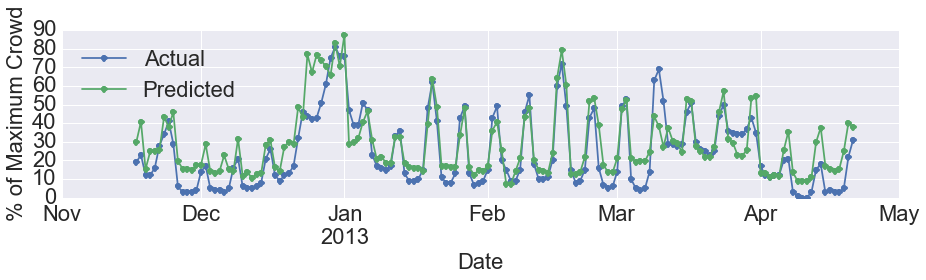

In [70]:
plot_fitted_and_ref_vs_time(df_H_lin, ref_column, ['2012-11-1 00:00:00', '2013-05-1 00:00:00'], 1200, (15,3), '% of Maximum Crowd')

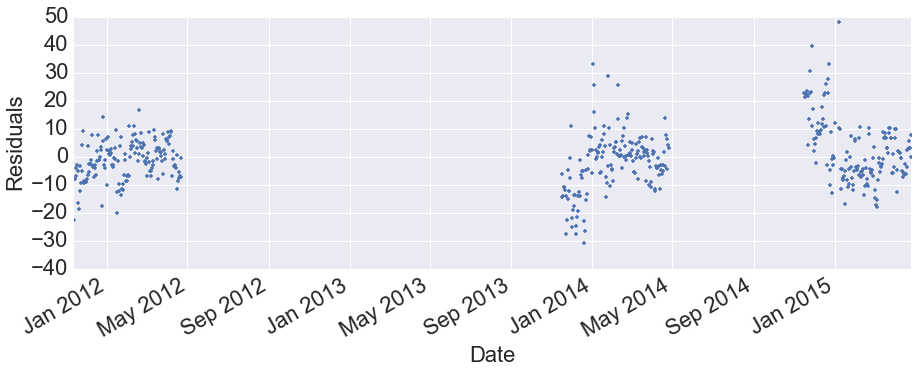

In [60]:
plot_resid_vs_time(df_cv_lin)

### Lasso

In [18]:
features = list(df.columns.values)
features.remove('skiers')

In [19]:
def find_training_and_hold_sets(df_tr, df_h, features):
    X_tr = df_tr[features]
    y_tr = df_tr.skiers.values
    X_h = df_h[features]
    y_h = df_h.skiers.values
    return X_tr, y_tr, X_h, y_h

In [20]:
X_tr, y_tr, X_h, y_h = find_training_and_hold_sets(df_tr, df_h, features)

In [21]:
best_lambda, lambda_lasso, coefs, mean_score_lambda = find_best_lambda(linear_model.Lasso, features, X_tr, y_tr, 1e-5, 10000000, 1.5)

Best Lambda: 4.0


/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


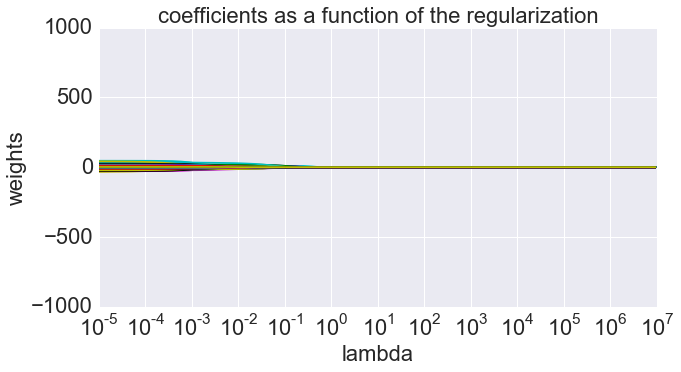

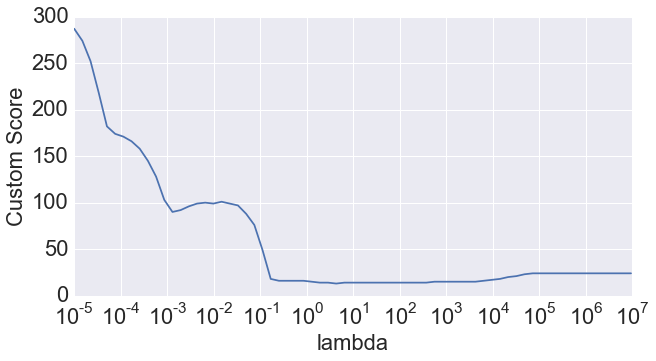

In [22]:
plot_lambda(lambda_lasso, coefs, mean_score_lambda, (-1000,1000))

#### Find cross-validation and holdout RMSE

In [23]:
clf = linear_model.Lasso(alpha=best_lambda)

In [24]:
RMSE_ls_H, RMSE_ls_CV, df_ls_hold, df_ls_cv = get_holdout_RMSE(clf, features, df_tr, df_h, ref_column)

CV RMSE: 13.5 ,  Holdout RMSE: 13.2


#### Plot the holdout lasso prediction vs the reference data

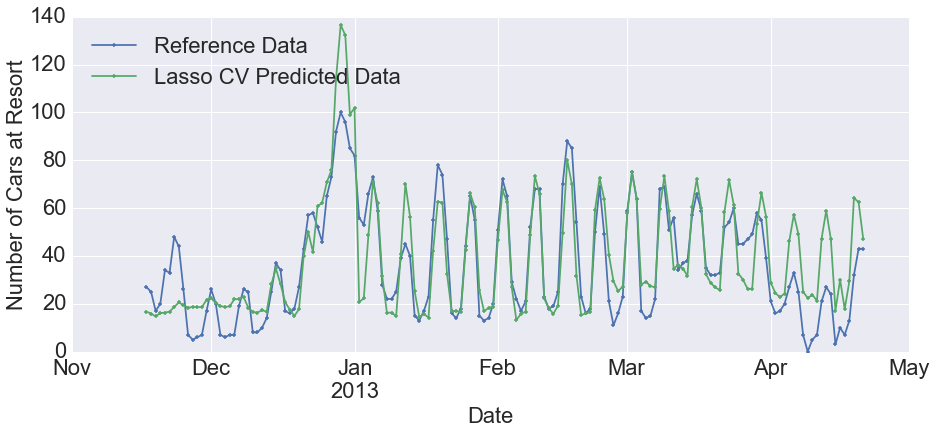

In [25]:
plot_lasso_and_ref_vs_time(df_ls_hold, ref_column, ['2012-11-1 00:00:00', '2013-05-1 00:00:00'])

## Random Forest

In [13]:
features = fs_features

In [14]:
X_tr = df_tr[features]
y_tr = df_tr.skiers.values
X_h = df_h[features]
y_h = df_h.skiers.values

#### Fit the random forest regressor and find cross-validation stats

In [16]:
rfr = RandomForestRegressor(n_estimators = 150, oob_score = True, n_jobs = -1, max_features='sqrt')

In [17]:
RMSE_rf_H, RMSE_rf_CV, df_rf_hold, df_rf_cv = get_holdout_RMSE(rfr, features, df_tr, df_h, ref_column)

CV RMSE: 13.6 ,  Holdout RMSE: 11.8


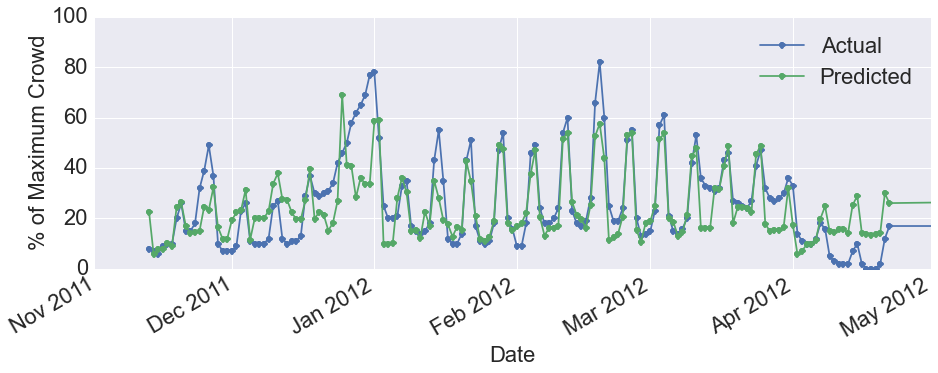

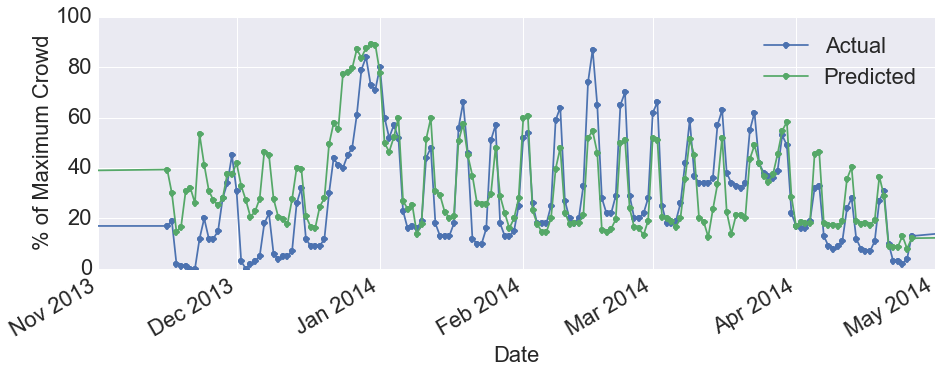

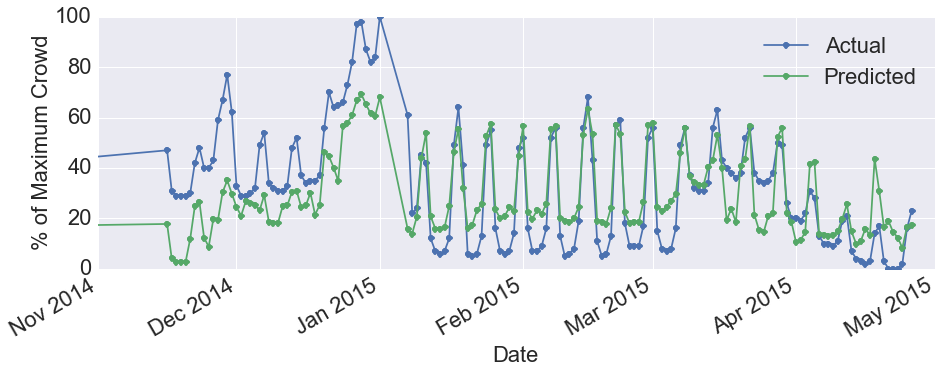

In [18]:
plot_fitted_and_ref_vs_time(df_rf_cv, 'skiers', ['2011-11-1 00:00:00', '2012-05-1 00:00:00'], RMSE_rf_CV, (15,5), '% of Maximum Crowd')
plot_fitted_and_ref_vs_time(df_rf_cv, 'skiers', ['2013-11-1 00:00:00', '2014-05-1 00:00:00'], RMSE_rf_CV, (15,5), '% of Maximum Crowd')
plot_fitted_and_ref_vs_time(df_rf_cv, 'skiers', ['2014-11-1 00:00:00', '2015-05-1 00:00:00'], RMSE_rf_CV, (15,5), '% of Maximum Crowd')

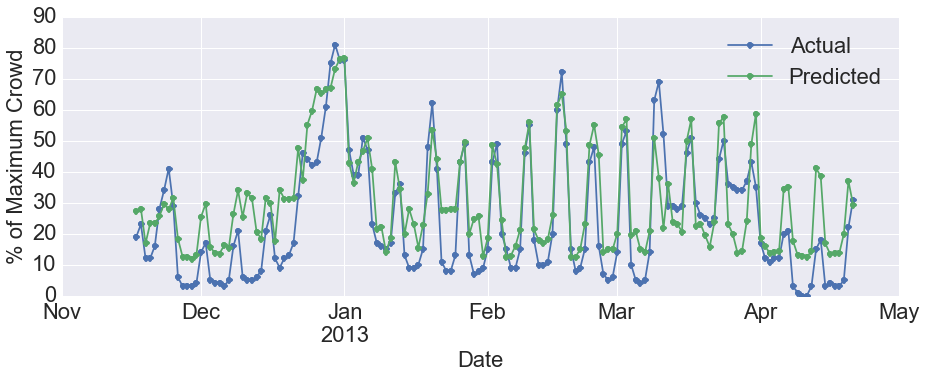

In [19]:
plot_fitted_and_ref_vs_time(df_rf_hold, 'skiers', ['2012-11-1 00:00:00', '2013-05-1 00:00:00'], RMSE_rf_H, (15,5), '% of Maximum Crowd')

### Get bootstrap estimates of confidence intervals to the dataframe.

In [71]:
X_fut = df_fut[best_features]
df_pred = run_bootstrap_model(df_cv, lin_regr, best_features, X_fut, ref_column)
df_fut = add_pred_and_conf_int_to_df(df_pred, df_fut)
df_fut['resid'] = np.abs(df_fut.skiers - df_fut.pred)

/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:688: DeprecationWarning: Bootstrap will no longer be supported as a cross-validation method as of version 0.15 and will be removed in 0.17
  "will be removed in 0.17", DeprecationWarning)
functions.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_fut['pred'] = pred_mean
functions.py:338: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_fut['st_dev'] = pred_std
functions.py:339: SettingWithCopyWarning: 
A value is trying to be set on a copy

#### Add a 'day of week' column to the df.

In [72]:
day_of_week = []
for idx, day in df_fut.iterrows():
    day_of_week.append(idx.weekday())
    
df_fut['day_of_week'] = day_of_week

/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Export Data

In [73]:
df_fut.to_csv('../webpage_ski/df_all_features.csv')